## Import Packages

In [70]:
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


## Read File

In [71]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]


## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [72]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")


/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [73]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'
        

## Data Classifier

In [74]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality


## Split dataset into x and y and one-hot encode quality column

In [75]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = OneHotEncoder().fit_transform(new_data[['quality']]).toarray()


## Train test split

In [76]:

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=10)


## Scale the data to Improve the speed of training Model

In [77]:
!pip install matplotlib

range of the xTrain:
n_tokens_title                   1.800000e+01
n_tokens_content                 7.053000e+03
n_unique_tokens                  7.857646e-01
n_non_stop_words                 5.237800e-08
n_non_stop_unique_tokens         8.259740e-01
num_hrefs                        3.040000e+02
num_self_hrefs                   4.400000e+01
num_imgs                         1.000000e+02
num_videos                       6.600000e+01
average_token_length             4.441534e+00
num_keywords                     9.000000e+00
data_channel_is_lifestyle        1.000000e+00
data_channel_is_entertainment    1.000000e+00
data_channel_is_bus              1.000000e+00
data_channel_is_socmed           1.000000e+00
data_channel_is_tech             1.000000e+00
data_channel_is_world            1.000000e+00
kw_min_min                       3.780000e+02
kw_max_min                       4.010000e+04
kw_avg_min                       5.865571e+03
kw_min_max                       8.433000e+05
kw_max_max   

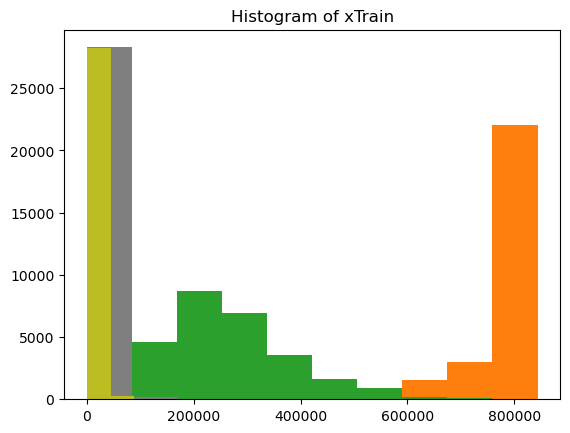

In [78]:

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


scaler = MinMaxScaler()
scale_xTrain = scaler.fit_transform(xTrain)
scale_xTest = scaler.fit_transform(xTest)

print("range of the xTrain:")
print(xTrain.max() - xTrain.min())
for i in xTrain.columns:
    plt.hist(xTrain[i])
plt.title("Histogram of xTrain")
plt.show()



## Create and train model(NN)

In [79]:
def build_nn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mirror_strategy = tf.distribute.MirroredStrategy()
with mirror_strategy.scope():
    nn_model1 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])
    nn_model2 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])

    fit_speed = tf.data.Dataset.from_tensor_slices((scale_xTrain, yTrain))
    fit_speed = fit_speed.repeat().batch(100)

    nn_model1.fit(scale_xTrain, yTrain, epochs=10)
    nn_model2.fit(scale_xTrain, yTrain, epochs=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/10
  1/892 [..............................] - ETA: 2:00 - loss: 1.4947 - accuracy: 0.1562

2023-08-31 21:53:04.563520: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


892/892 [==============================] - 1s 552us/step - loss: 1.2318 - accuracy: 0.4197
Epoch 2/10
892/892 [==============================] - 1s 560us/step - loss: 1.2120 - accuracy: 0.4298
Epoch 3/10
892/892 [==============================] - 0s 543us/step - loss: 1.2027 - accuracy: 0.4371
Epoch 4/10
892/892 [==============================] - 0s 555us/step - loss: 1.1977 - accuracy: 0.4385
Epoch 5/10
892/892 [==============================] - 0s 546us/step - loss: 1.1937 - accuracy: 0.4387
Epoch 6/10
892/892 [==============================] - 0s 540us/step - loss: 1.1894 - accuracy: 0.4405
Epoch 7/10
892/892 [==============================] - 0s 556us/step - loss: 1.1842 - accuracy: 0.4460
Epoch 8/10
892/892 [==============================] - 0s 538us/step - loss: 1.1817 - accuracy: 0.4457
Epoch 9/10
892/892 [==============================] - 0s 540us/step - loss: 1.1764 - accuracy: 0.4497
Epoch 10/10
892/892 [==============================] - 0s 544us/step - loss: 1.1748 - accurac

## Create and train model(Random Forest)

In [80]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(scale_xTrain, yTrain.argmax(axis=1))


RandomForestClassifier()

## Make predictions with each model individually

In [81]:
nn1_train_pred = nn_model1.predict(scale_xTrain)
nn2_train_pred = nn_model2.predict(scale_xTrain)
RF_train_pred = RF_model.predict_proba(scale_xTrain)

nn1_test_pred = nn_model1.predict(scale_xTest)
nn2_test_pred = nn_model2.predict(scale_xTest)
RF_test_pred = RF_model.predict_proba(scale_xTest)

print("Shape:")
print("nn1_train_pred:", nn1_train_pred.shape)
print("nn2_train_pred:", nn2_train_pred.shape)
print("RF_train_pred:", RF_train_pred.shape)

nn1_train_labels = nn1_train_pred.argmax(axis=1)
nn2_train_labels = nn2_train_pred.argmax(axis=1)
RF_train_labels = RF_train_pred.argmax(axis=1)

nn1_test_labels = nn1_test_pred.argmax(axis=1)
nn2_test_labels = nn2_test_pred.argmax(axis=1)
RF_test_labels = RF_test_pred.argmax(axis=1)

print("Labels:")
print("nn1_train_pred:", nn1_train_labels)
print("nn2_train_pred:", nn2_train_labels)
print("RF_train_pred:", RF_train_labels)
print("nn1_test_pred:", nn1_test_labels)
print("nn2_test_pred:", nn2_test_labels)
print("RF_test_pred:", RF_test_labels)
print()

223/223 [==============================] - 0s 361us/step
Shape:
nn1_train_pred: (28543, 4)
nn2_train_pred: (28543, 4)
RF_train_pred: (28543, 4)
Labels:
nn1_train_pred: [0 3 0 ... 3 1 3]
nn2_train_pred: [3 3 0 ... 3 3 3]
RF_train_pred: [3 1 0 ... 3 3 1]
nn1_test_pred: [3 3 3 ... 2 3 3]
nn2_test_pred: [3 3 3 ... 2 3 3]
RF_test_pred: [0 3 3 ... 2 3 3]



## Simple Ensemble: 3 linear models

## Train the 3 linear models

In [83]:
from sklearn.linear_model import LinearRegression
linmodel_1 = LinearRegression()
linmodel_2 = LinearRegression()
linmodel_3 = LinearRegression()

linmodel_1.fit(scale_xTrain,yTrain)
linmodel_2.fit(scale_xTrain,yTrain)
linmodel_3.fit(scale_xTrain,yTrain)

LinearRegression()

## Get the predictions out of the 3 linear regression models

In [82]:
linmodel1_train_pred = linmodel_1.predict(scale_xTrain)
linmodel2_train_pred = linmodel_2.predict(scale_xTrain)
linmodel3_train_pred = linmodel_3.predict(scale_xTrain)

linmodel1_test_pred = linmodel_1.predict(scale_xTest)
linmodel2_test_pred = linmodel_2.predict(scale_xTest)
linmodel3_test_pred = linmodel_3.predict(scale_xTest)

## Get the ensemble prediction

In [84]:
ensemble_simple_train_pred = (linmodel1_train_pred + linmodel2_train_pred + linmodel3_train_pred) / 3
ensemble_simple_test_pred = (linmodel1_test_pred + linmodel2_test_pred + linmodel3_test_pred) / 3

ensemble_simple_train_labels = ensemble_simple_train_pred.argmax(axis=1)
ensemble_simple_test_labels = ensemble_simple_test_pred.argmax(axis=1)

## (Simple Ensemble) Classification Report 

In [85]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_simple_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_simple_test_labels))

print("Training error")

Train:
              precision    recall  f1-score   support

           0       0.29      0.65      0.40      8380
           1       0.38      0.02      0.03      6019
           2       0.30      0.01      0.01      2952
           3       0.38      0.32      0.35     11192

    accuracy                           0.32     28543
   macro avg       0.34      0.25      0.20     28543
weighted avg       0.35      0.32      0.26     28543

Test:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46      2108
           1       0.00      0.00      0.00      1549
           2       0.00      0.00      0.00       678
           3       0.00      0.00      0.00      2801

    accuracy                           0.30      7136
   macro avg       0.07      0.25      0.11      7136
weighted avg       0.09      0.30      0.13      7136

Training error


/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Complex Ensemble: 2 NN + 1 RF

In [86]:
ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3

ensemble_train_labels = ensemble_train_pred.argmax(axis=1)
ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

print("ensemble_train_labels:",ensemble_train_labels)
print("ensemble_train_labels:",ensemble_train_labels)


ensemble_train_labels: [3 1 0 ... 3 3 3]
ensemble_train_labels: [3 1 0 ... 3 3 3]


## Model Evaluation

In [87]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_test_labels))


Train:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8380
           1       0.94      0.82      0.88      6019
           2       1.00      0.60      0.75      2952
           3       0.85      0.97      0.90     11192

    accuracy                           0.88     28543
   macro avg       0.91      0.82      0.85     28543
weighted avg       0.89      0.88      0.88     28543

Test:
              precision    recall  f1-score   support

           0       0.53      0.36      0.43      2108
           1       0.39      0.27      0.32      1549
           2       0.25      0.07      0.11       678
           3       0.43      0.69      0.53      2801

    accuracy                           0.44      7136
   macro avg       0.40      0.35      0.35      7136
weighted avg       0.44      0.44      0.41      7136



In [88]:
from sklearn.metrics import accuracy_score
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)
nn2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn2_train_labels)
RF_train_accuracy = accuracy_score(yTrain.argmax(axis=1), RF_train_labels)

nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)
nn2_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn2_test_labels)
RF_test_accuracy = accuracy_score(yTest.argmax(axis=1), RF_test_labels)

ensemble_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
ensemble_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)

print("Model Train Accuracies:")
print(f"Neural Network 1: {nn1_train_accuracy:.4f}")
print(f"Neural Network 2: {nn2_train_accuracy:.4f}")
print(f"Random Forest: {RF_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"Neural Network 1: {nn1_test_accuracy:.4f}")
print(f"Neural Network 2: {nn2_test_accuracy:.4f}")
print(f"Random Forest: {RF_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_test_accuracy:.4f}")

Model Train Accuracies:
Neural Network 1: 0.4598
Neural Network 2: 0.4655
Random Forest: 1.0000

Model Test Accuracies:
Neural Network 1: 0.4301
Neural Network 2: 0.4409
Random Forest: 0.4261

Ensemble Model:
Training Accuracy: 0.8786
Testing Accuracy: 0.4410
